In [3]:
### Reading Data
import numpy as np
import pandas as pd

train_data = pd.read_csv('train_selected.csv')
test_data = pd.read_csv('test_selected.csv')

# Load the true TTF values
with open('PM_truth.txt', 'r') as file:
    y_test_truth = [int(line.strip()) for line in file]
    y_test_truth = np.array(y_test_truth)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Extract relevant columns
train_features = train_data[['s1', 's2', 's3', 's4']]
train_cycles = train_data['cycle']

train_ttf = train_data['ttf']
train_class_label = train_data['label_bnc']

test_features = test_data[['s1', 's2', 's3', 's4']]
test_cycles = test_data['cycle']

# Normalize the sensor data using Min-Max Scaling
scaler = MinMaxScaler()

#transform both train and test data
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Convert back to DataFrames
train_features_scaled = pd.DataFrame(train_features_scaled, columns=['s1', 's2', 's3', 's4'])
test_features_scaled = pd.DataFrame(test_features_scaled, columns=['s1', 's2', 's3', 's4'])

# Combine the scaled features back with other relevant data
train_preprocessed = pd.concat([train_data['id'], train_cycles, train_features_scaled, train_ttf, train_class_label], axis=1)
test_preprocessed = pd.concat([test_data['id'], test_cycles, test_features_scaled], axis=1)


In [6]:
# Creating test classification labels
y_test_class = (y_test_truth <= 30).astype(int)

# print(y_test_class) - to check values

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prepare features and labels
X_train = train_features_scaled
y_train = train_class_label

# Initialise and train the Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=7,
    min_samples_split=2,
    random_state=42,
    class_weight=None
)
rf_classifier.fit(X_train, y_train)

y_test_pred = rf_classifier.predict(test_features_scaled)

# Evaluate the model
print("Test Results:")
print(f"Accuracy: {accuracy_score(y_test_class, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test_class, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test_class, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test_class, y_test_pred):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_class, y_test_pred)}")


Test Results:
Accuracy: 0.8900
Precision: 0.8500
Recall: 0.6800
F1-Score: 0.7556
Confusion Matrix:
[[72  3]
 [ 8 17]]


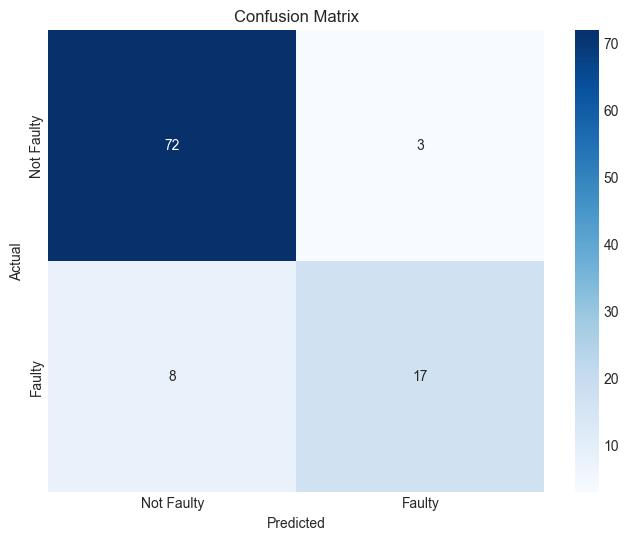

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_class, y_test_pred)

# Plot the confusion matrix
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Faulty", "Faulty"], yticklabels=["Not Faulty", "Faulty"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 7],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 5, 7],
    'class_weight': [None]
}

# Initialisation of Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    scoring='recall',  # Using recall as the evaluation metric
    cv=5,
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Recall:", grid_search.best_score_)

# Update Predictions
best_rf_classifier = grid_search.best_estimator_
y_test_pred = best_rf_classifier.predict(test_features_scaled)

Best Parameters: {'class_weight': None, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100}
Best Recall: 0.7748387096774193

Test Results with Best Parameters:
Accuracy: 0.8900
Precision: 0.8500
Recall: 0.6800
F1-Score: 0.7556
